<a href="https://colab.research.google.com/github/geekevgin/-Python/blob/main/Belousova_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import random
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import stats
from scipy.stats import mannwhitneyu,ttest_ind, kruskal,chisquare, pearsonr, spearmanr




In [2]:

# Функция описания числовых данных
def describe_numerical_var(series):
    p75 = series.quantile(0.75)
    p25 = series.quantile(0.25)
    IQR = p75 - p25
    series.hist()
    print(series.describe(), '\n')
    print('IQR = {}'.format(IQR))
    print('Outliers: {} and {}\n'.format(p25 - 1.5*IQR, p75 + 1.5*IQR))
    print('Column has {} ({}%) missing values\n'.
          format(series.isnull().sum(), series.isnull().sum()/len(series)))

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))


In [4]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [42]:
df = pd.read_csv('/content/final_ab_ds.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54976 entries, 0 to 54975
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      54976 non-null  int64  
 1   person_id       54976 non-null  int64  
 2   procalcitonine  54976 non-null  float64
 3   fibrinogen      42093 non-null  float64
 4   creatinine      54967 non-null  float64
 5   wbc             54970 non-null  float64
 6   hb              54970 non-null  float64
 7   plt             54957 non-null  float64
 8   crp             54930 non-null  float64
 9   esr             46623 non-null  float64
 10  lymph           54928 non-null  float64
 11  pneumonia       54976 non-null  int64  
 12  ihd             54976 non-null  int64  
 13  dm              54976 non-null  int64  
 14  ah              54976 non-null  int64  
 15  sex             54976 non-null  int64  
 16  len             54976 non-null  int64  
 17  age             54976 non-null 

In [6]:
print(df.isna().sum())

Unnamed: 0            0
person_id             0
procalcitonine        0
fibrinogen        12883
creatinine            9
wbc                   6
hb                    6
plt                  19
crp                  46
esr                8353
lymph                48
pneumonia             0
ihd                   0
dm                    0
ah                    0
sex                   0
len                   0
age                   0
GFR                   9
ab_indication         0
dtype: int64


In [7]:
print(df.describe())

          Unnamed: 0     person_id  procalcitonine    fibrinogen  \
count   54976.000000  54976.000000    54976.000000  42093.000000   
mean   499314.284451    659.780395        0.223792      8.220702   
std    288597.632943    376.040698        0.191438      2.748833   
min        15.000000    108.000000        0.000000      2.440000   
25%    249096.000000    301.000000        0.049803      6.307715   
50%    499504.000000    693.000000        0.177972      8.191811   
75%    749512.250000   1098.000000        0.449995     10.102178   
max    999995.000000   1103.000000        0.805360     18.000000   

         creatinine           wbc            hb           plt           crp  \
count  54967.000000  54970.000000  54970.000000  54957.000000  54930.000000   
mean       0.954802     19.745137    136.281311    365.141972     40.803944   
std        0.129617     12.962810     13.409629    195.828885     33.793132   
min        0.667421      0.410000     85.000000      4.100000      0.80

In [43]:
df = df.dropna()

In [44]:
neg, pos = np.bincount(df['ab_indication'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.1f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 35680
    Positive: 8873 (24.9% of total)



In [10]:
df.head()

,Unnamed: 0,person_id,procalcitonine,fibrinogen,creatinine,wbc,hb,plt,crp,esr,lymph,pneumonia,ihd,dm,ah,sex,len,age,GFR,ab_indication
1,3822,158,0.000000,8.909846,1.030282,1.363834,143.647123,644.437365,58.343027,34.424705,23.300684,1,0,0,0,1,17,56,60.894798,0
2,915492,342,0.000000,7.092240,1.027174,25.710224,130.864644,483.261016,0.800000,25.493102,27.004637,1,0,0,0,1,34,56,61.117621,0
3,641908,108,0.134918,13.265546,0.707201,0.410000,141.945473,477.671705,7.526411,46.599795,17.167563,1,0,0,0,1,26,56,95.972393,0
4,89879,108,0.000000,15.336425,1.094880,12.546527,120.607466,704.633325,27.180197,35.411333,15.268175,1,0,0,0,1,28,56,56.578279,0
5,744110,980,0.324985,9.899282,1.265045,7.001120,125.988145,166.613698,0.800000,27.280940,12.404405,1,1,0,0,1,33,48,50.257856,0


In [11]:
df_num_features_float = df.select_dtypes( include = 'float64')
df_num_features_float.head()

,procalcitonine,fibrinogen,creatinine,wbc,hb,plt,crp,esr,lymph,GFR
1,0.000000,8.909846,1.030282,1.363834,143.647123,644.437365,58.343027,34.424705,23.300684,60.894798
2,0.000000,7.092240,1.027174,25.710224,130.864644,483.261016,0.800000,25.493102,27.004637,61.117621
3,0.134918,13.265546,0.707201,0.410000,141.945473,477.671705,7.526411,46.599795,17.167563,95.972393
4,0.000000,15.336425,1.094880,12.546527,120.607466,704.633325,27.180197,35.411333,15.268175,56.578279
5,0.324985,9.899282,1.265045,7.001120,125.988145,166.613698,0.800000,27.280940,12.404405,50.257856


Analyzing 'procalcitonine' column
count    35680.000000
mean         0.223226
std          0.191179
min          0.000000
25%          0.049837
50%          0.177051
75%          0.442477
max          0.803586
Name: procalcitonine, dtype: float64 

IQR = 0.39264099170064115
Outliers: -0.5391249826032474 and 1.0314389841993172

Column has 0 (0.0%) missing values

Analyzing 'fibrinogen' column
count    35680.000000
mean         8.221106
std          2.743891
min          2.440000
25%          6.313580
50%          8.190892
75%         10.098011
max         18.000000
Name: fibrinogen, dtype: float64 

IQR = 3.7844312654856864
Outliers: 0.6369329507647734 and 15.774658012707519

Column has 0 (0.0%) missing values

Analyzing 'creatinine' column
count    35680.000000
mean         0.955292
std          0.129787
min          0.667421
25%          0.867231
50%          0.955109
75%          1.042678
max          1.478885
Name: creatinine, dtype: float64 

IQR = 0.17544647500500032
Outliers: 0.6

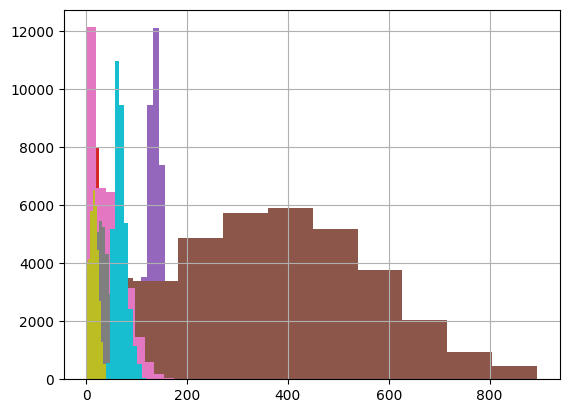

In [12]:
for column in df_num_features_float:
    print('Analyzing \'{}\' column'.format(column))
    describe_numerical_var(df[column])

In [13]:
df_num_features_int = df.select_dtypes( include = 'int64')
df_num_features_int.head()

,Unnamed: 0,person_id,pneumonia,ihd,dm,ah,sex,len,age,ab_indication
1,3822,158,1,0,0,0,1,17,56,0
2,915492,342,1,0,0,0,1,34,56,0
3,641908,108,1,0,0,0,1,26,56,0
4,89879,108,1,0,0,0,1,28,56,0
5,744110,980,1,1,0,0,1,33,48,0


Analyzing 'Unnamed: 0' column
count     35680.000000
mean     499485.993217
std      288422.652934
min          15.000000
25%      250343.750000
50%      499547.000000
75%      749060.750000
max      999995.000000
Name: Unnamed: 0, dtype: float64 

IQR = 498717.0
Outliers: -497731.75 and 1497136.25

Column has 0 (0.0%) missing values

Analyzing 'person_id' column
count    35680.000000
mean       657.172197
std        376.492681
min        108.000000
25%        297.000000
50%        688.000000
75%       1097.000000
max       1103.000000
Name: person_id, dtype: float64 

IQR = 800.0
Outliers: -903.0 and 2297.0

Column has 0 (0.0%) missing values

Analyzing 'pneumonia' column
count    35680.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: pneumonia, dtype: float64 

IQR = 0.0
Outliers: 1.0 and 1.0

Column has 0 (0.0%) missing values

Analyzing 'ihd' column
count    35680.000000
mean         0.328447
std         

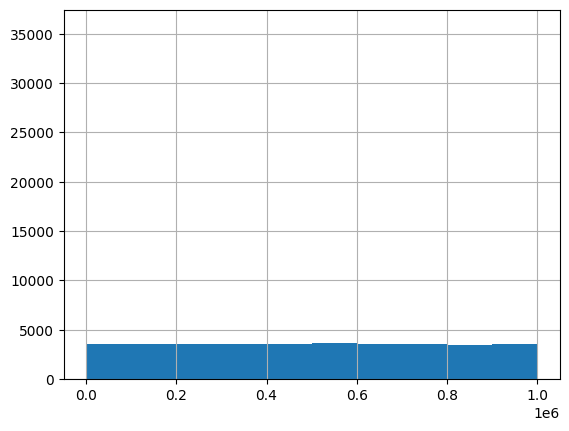

In [14]:
for column in df_num_features_int:
    print('Analyzing \'{}\' column'.format(column))
    describe_numerical_var(df[column])

In [45]:
columns =['plt', 'esr', 'fibrinogen', 'creatinine', 'wbc',  'crp','lymph']
df_no_ind = df[df['ab_indication'] == 0]
df_ind = df[df['ab_indication'] == 1]


In [16]:
import warnings
warnings.filterwarnings('ignore')
for i in columns:
  lst1 = df_no_ind[i]
  lst2 = df_ind[i]
  shapiro_test = stats.shapiro(lst1) # тест шапиро-уилка
  shapiro_test2 = stats.shapiro(lst2) # тест шапиро-уилка
  if shapiro_test[1] < .05:
    print('Данные {0} распределены ненормально,\
           p-value - {1}'.format(i,  shapiro_test[1]))
  if shapiro_test2[1] < .05:
    print('Данные {0} распределены ненормально,\
           p-value - {1}'.format(i,  shapiro_test2[1]))
  else:
    pass

Данные plt распределены ненормально,           p-value - 1.7142533019814427e-20
Данные plt распределены ненормально,           p-value - 0.0
Данные esr распределены ненормально,           p-value - 1.1145927985239595e-40
Данные esr распределены ненормально,           p-value - 1.4016444175928051e-30
Данные fibrinogen распределены ненормально,           p-value - 9.587672119282562e-20
Данные fibrinogen распределены ненормально,           p-value - 4.379362085706425e-27
Данные creatinine распределены ненормально,           p-value - 1.95159155019103e-23
Данные creatinine распределены ненормально,           p-value - 3.3187122212667564e-13
Данные wbc распределены ненормально,           p-value - 0.0
Данные wbc распределены ненормально,           p-value - 9.937696198009841e-29
Данные crp распределены ненормально,           p-value - 0.0
Данные crp распределены ненормально,           p-value - 9.361197117922101e-34
Данные lymph распределены ненормально,           p-value - 1.46516323598696

In [17]:
import warnings
warnings.filterwarnings('ignore')
for i in columns:
  lst1 = df_no_ind[i]
  lst2 = df_ind[i]
  t_test = stats.ttest_ind(lst1, lst2) # T- тест , средние значения не равны, что данные статистически значимо отличаются в группах.
#но тк данные распределены ненормально, то воспользуемся непараметрическими тестами
  if t_test[1] < .05:
    print('Гипотеза о равенствне средних значений данных {0} отвергается,\
           p-value - {1}'.format(i,  t_test[1]))
  else:
    pass









Гипотеза о равенствне средних значений данных plt отвергается,           p-value - 0.0
Гипотеза о равенствне средних значений данных esr отвергается,           p-value - 2.1921373116344525e-126
Гипотеза о равенствне средних значений данных fibrinogen отвергается,           p-value - 0.0
Гипотеза о равенствне средних значений данных creatinine отвергается,           p-value - 0.00038383048715605946
Гипотеза о равенствне средних значений данных wbc отвергается,           p-value - 1.0511236917573139e-243
Гипотеза о равенствне средних значений данных crp отвергается,           p-value - 0.0
Гипотеза о равенствне средних значений данных lymph отвергается,           p-value - 0.0


In [18]:
def Basic_statistics(lst_1, lst_2):
    """
    Функция "Базовые статистики"

    На вход получает 2 списка данных для сравнения.
    На выходе получаем p-values, при сравнении признаков.
    В частности: показаны, не показаны антибиотики
    """
    res_kw = kruskal(lst_1, lst_2)## краскела уолиса
    anova = stats.f_oneway(lst_1, lst_2) #тест анова
    return res_kw[1],  anova[1]

In [19]:
for col in columns:
  lst1 = df_no_ind[col]
  lst2 = df_ind[col]
  kw =  Basic_statistics(lst1, lst2)[0]
  an =  Basic_statistics(lst1, lst2)[1]
  if kw < .05:
    print('Данные {0} статисически значимо различаются в подгруппах,\
           p-value - {1}, тест Крускала-Уоллиса'.format(col,  kw))
  if an < .05:
    print('Данные {0} статисически значимо различаются в подгруппах,\
           p-value - {1}, тест Анова'.format(col,  an))
  else:
    pass


Данные plt статисически значимо различаются в подгруппах,           p-value - 0.0, тест Крускала-Уоллиса
Данные plt статисически значимо различаются в подгруппах,           p-value - 0.0, тест Анова
Данные esr статисически значимо различаются в подгруппах,           p-value - 2.7536251235414657e-121, тест Крускала-Уоллиса
Данные esr статисически значимо различаются в подгруппах,           p-value - 2.1921373115857108e-126, тест Анова
Данные fibrinogen статисически значимо различаются в подгруппах,           p-value - 0.0, тест Крускала-Уоллиса
Данные fibrinogen статисически значимо различаются в подгруппах,           p-value - 0.0, тест Анова
Данные creatinine статисически значимо различаются в подгруппах,           p-value - 0.003026493786471801, тест Крускала-Уоллиса
Данные creatinine статисически значимо различаются в подгруппах,           p-value - 0.0003838304871477176, тест Анова
Данные wbc статисически значимо различаются в подгруппах,           p-value - 9.49496142847372e-224, 

In [46]:
#разобьем признаки на целевую, числовые
TARGET_NAME = 'ab_indication'
person = 'person_id'
BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME, person).tolist()


In [47]:
NUMB_FEATURE_NAMES = ['procalcitonine', 'fibrinogen', 'creatinine', 'wbc', 'hb', 'plt', 'crp', 'esr', 'lymph', 'pneumonia',
                      'ihd',	'dm',	'ah', 'sex', 'len', 'age', 'GFR']

In [48]:
#Нормализация
scaler = StandardScaler()
df_norm = df.copy()
df_norm[NUMB_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMB_FEATURE_NAMES])
df_train = df_norm.copy()


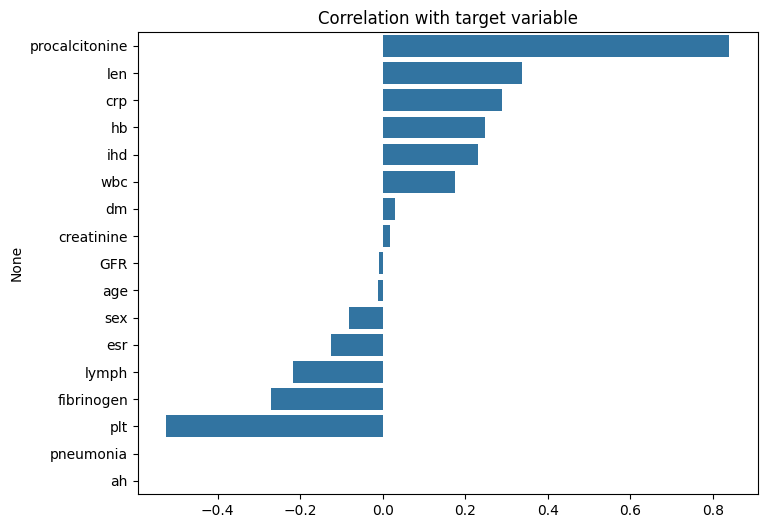

In [26]:
#посмотрим как коррелируют признаки с целевой без признаков person_id и Unnamed: 0
corr_with_target = df_train[NUMB_FEATURE_NAMES +
                            [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(8, 6))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [32]:
# разделяем набор данных на тренировочную, тестовую части
X = df_train.drop('ab_indication', axis=1)
Y = df_train['ab_indication']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size = 0.20,
                                                    stratify = Y,
                                                    random_state = 42)


In [33]:
df_train['ab_indication'].value_counts(normalize=True)*100 # есть дисбаланс данных

0    75.131726
1    24.868274
Name: ab_indication, dtype: float64

In [28]:
# На данном этапе возник вопрос на счет балансировки данных
# С одной стороны всегда стремимся устранить дисбаланс
# С другой, устраняя, дисбаланс как сильно это повлияет на итоговую картину. Не будет ли модель никому не назначать препарат

In [34]:
#балансировка данных.
df_for_balancing = pd.concat([X_train, Y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)

df_balanced[TARGET_NAME].value_counts()

0    21446
1    21294
Name: ab_indication, dtype: int64

In [30]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [36]:
print(X_train.shape)
print(Y_train.shape)

(28544, 19)
(28544,)


In [35]:
#LogisticRegression
model_lr = LogisticRegression()
model_lr.fit(X_train, Y_train)

Y_train_pred = model_lr.predict(X_train)
Y_test_pred = model_lr.predict(X_test)

get_classification_report(Y_train, Y_train_pred, Y_test, Y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.81      0.80     21446
           1       0.40      0.38      0.39      7098

    accuracy                           0.70     28544
   macro avg       0.60      0.59      0.60     28544
weighted avg       0.70      0.70      0.70     28544

TEST

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      5361
           1       0.39      0.38      0.38      1775

    accuracy                           0.70      7136
   macro avg       0.59      0.59      0.59      7136
weighted avg       0.69      0.70      0.70      7136

CONFUSION MATRIX

col_0             0     1
ab_indication            
0              4312  1049
1              1107   668


In [ ]:
# По Train оценим precision и recall для класса 0 выше, чем для класса 1, те модель хорошо классифицирует данные класса 0.
# По Test precision и recall для обоих классов ниже, чем на обучающей выборке. Что указывает на переобучение, различие данных
# По CONFUSION MATRIX результат работы модели по тестовой выборке: столбец 0 - модель верно определила данные, столбец 1 - неверно

In [49]:
# разделяем набор данных на тренировочную, тестовую части
X = df_train.drop('ab_indication', axis=1)
Y = df_train['ab_indication']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size = 0.20,
                                                    stratify = Y,
                                                    random_state = 42)

In [50]:
df_train['ab_indication'].value_counts(normalize=True)*100 # попробуем с разбалансироваными данными

0    75.131726
1    24.868274
Name: ab_indication, dtype: float64

In [40]:
print(X_train.shape)
print(Y_train.shape)

(28544, 19)
(28544,)


In [51]:
#LogisticRegression. Модель также переобучена.
model_lr = LogisticRegression()
model_lr.fit(X_train, Y_train)

Y_train_pred = model_lr.predict(X_train)
Y_test_pred = model_lr.predict(X_test)

get_classification_report(Y_train, Y_train_pred, Y_test, Y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.80      0.81      0.80     21446
           1       0.40      0.38      0.39      7098

    accuracy                           0.70     28544
   macro avg       0.60      0.59      0.60     28544
weighted avg       0.70      0.70      0.70     28544

TEST

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      5361
           1       0.39      0.38      0.38      1775

    accuracy                           0.70      7136
   macro avg       0.59      0.59      0.59      7136
weighted avg       0.69      0.70      0.70      7136

CONFUSION MATRIX

col_0             0     1
ab_indication            
0              4312  1049
1              1107   668


In [61]:
# разделяем набор данных на тренировочную, тестовую и валидационную части и нормализуем данные
X = df.drop('ab_indication', axis=1)
Y = df['ab_indication']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size = 0.20,
                                                    stratify = Y,
                                                    random_state = 42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train,
                                                  test_size = 0.20,
                                                  stratify = Y_train,
                                                  random_state = 42)

In [62]:
from sklearn.model_selection import GridSearchCV #попробуем найти наилучшие параметры для модели,

grid = {'C': np.logspace(-3,3,7), 'penalty': ['l1', 'l2']}
lr = LogisticRegression()
lr_cv = GridSearchCV(lr, grid, cv=10)
lr_cv.fit(X_val, Y_val)

print('параметры: ', lr_cv.best_params_)


параметры:  {'C': 0.1, 'penalty': 'l2'}


In [63]:
model_lr = LogisticRegression(C=0.1, penalty='l2') # модель все также показывает переобучение
model_lr.fit(X_train, Y_train)

Y_train_pred = model_lr.predict(X_train)
Y_test_pred = model_lr.predict(X_test)

get_classification_report(Y_train, Y_train_pred, Y_test, Y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     17157
           1       0.67      0.62      0.64      5678

    accuracy                           0.83     22835
   macro avg       0.77      0.76      0.77     22835
weighted avg       0.83      0.83      0.83     22835

TEST

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      5361
           1       0.68      0.62      0.65      1775

    accuracy                           0.83      7136
   macro avg       0.78      0.76      0.77      7136
weighted avg       0.83      0.83      0.83      7136

CONFUSION MATRIX

col_0             0     1
ab_indication            
0              4844   517
1               676  1099


In [ ]:
#Возможно LogReg не лучшая модель для этих данных, возможно так данные синтетичские. Что является причиной переобучения модели
#ТК была поставлена задача поиска пациентов, которым необходимо назначение антибиотка(аб), то необходимо максимализировать Precision, тк не ошибиться
# в данном случае критически важно, тк от этого будет зависть прогноз течения заболевания и исход.
# Recall. Показывает количество классификаций. Лучше в лишний раз предположить заболевание у здорового человека, чем пропустить его.
# Если максимизировать Precision, строго классифицируя результаты, то падает Recall, удаляя правильные ответы.
#При попытке повысить Recall, падает Precision, тк увеличивается количество FP.
# Поэтому лучше использовать метрику F1 для баланса Precision и Recall. F1 мера позволяет учесть обе характеристики одновременно.
